In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
%matplotlib inline

## Define functions to rotate velocities

In [2]:
import math

def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

## load test dataset

In [3]:
fname = '/home/z3526974/Work/data/dipole_work/dataset-duacs-rep-global-merged-allsat-phy-l4_1553210076192.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:    (latitude: 29, longitude: 29, time: 9292)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-06-10
  * latitude   (latitude) float32 -36.875 -36.625 -36.375 ... -30.125 -29.875
  * longitude  (longitude) float32 149.125 149.375 149.625 ... 155.875 156.125
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                      

## Define line for Hovmoller - make plot to show where it is

In [4]:
start_lon = 154
start_lat = -31

end_lon = 150.6
end_lat = -36.4

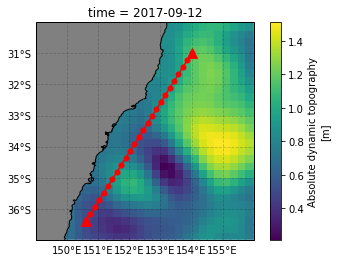

In [12]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

ax1 = plt.axes(projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
ds.adt.sel(time = '2017-09-12').plot(transform=ccrs.PlateCarree())
plt.plot(start_lon, start_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
plt.plot(end_lon, end_lat, color='red', marker='^',markersize = 10,transform=ccrs.PlateCarree())
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#make array of lats and lons for slicing
path_lats=np.linspace(start_lat,end_lat, 25)
path_lons=np.linspace(start_lon,end_lon, 25)
plt.plot(path_lons, path_lats, color='red', marker='o',markersize = 5)
#plt.savefig('dipole_section_location_AVISO.png', dpi=300,bbox_inches='tight')

## Extract section along this line for Hovmoller

In [13]:
# use xarray advanced interpolation interp - can't seem to do this pairwise for latlon pairs, for the moment doing it in a loop
section = []
for x in range(25):
    px = ds.sel(latitude=path_lats[x], longitude=path_lons[x],method = 'nearest') 
    section.append(px)
sec = xr.concat(section, dim=path_lats)

    

ang = np.deg2rad(27)
#rotate velocities normal to section
[u_rot, v_rot]=rotate(sec.ugos,sec.vgos,0,0, ang) 


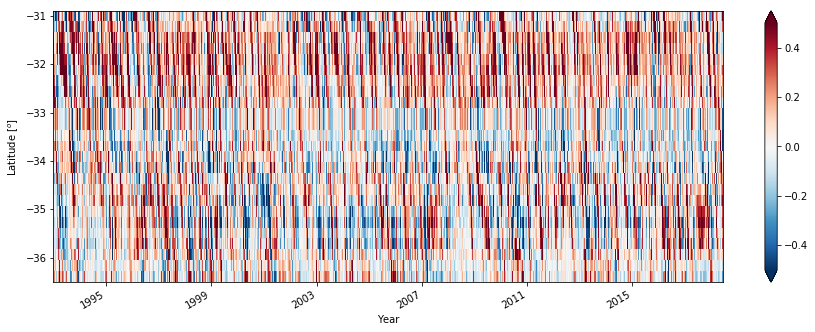

In [14]:
plt.figure(figsize=(15, 5))
u_rot.plot(vmin=-.5,vmax=.5,cmap='RdBu_r')
plt.ylabel('Latitude [$^o$]')
plt.xlabel('Year')
plt.savefig('dipole_hovemoller_AVISO.png', dpi=300,bbox_inches='tight')

## Plot time-mean of the Hovmoller

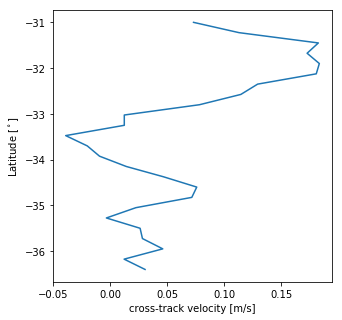

In [15]:
plt.figure(figsize=(5, 5))
u_rot.mean(axis = 1).plot(y='concat_dim')
plt.ylabel('Latitude [$^\circ$]')
plt.xlabel('cross-track velocity [m/s]')
plt.savefig('dipole_hovemoller_mean_AVISO.png', dpi=300,bbox_inches='tight')

## Get latitude of max onshore velocity at each timestep

In [16]:
u_rot.shape

(25, 9292)

In [17]:
onshore_lats=[]
for i in range(len(u_rot.time)):
    x = np.argmin(u_rot[:,i])
    ll = (x)
    onshore_lats.append(ll)
onshore_timeseries=path_lats[onshore_lats]

In [18]:
#get values at min of each column
ol=np.array(onshore_lats)
np.shape(ol)
onshore_u_min=u_rot[ol,:]

u_dipole=[]
for i in range(len(u_rot.time)):
    q = u_rot[ol[i],i]
    lll = (q)
    u_dipole.append(lll)
    

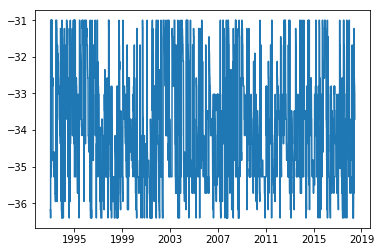

-33.95335503659061

In [19]:
mean_lat = np.mean(onshore_timeseries)
plt.plot(u_rot.time,onshore_timeseries)
plt.savefig('dipole_timeseries_AVISO.png', dpi=300,bbox_inches='tight')
plt.show()
mean_lat

In [26]:
onshore_lats = xr.concat(onshore_lats,dim='time')
onshore_lats

<xarray.DataArray (time: 9292)>
array([23, 23, 23, ..., 11, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-06-10

## Plot Histograms


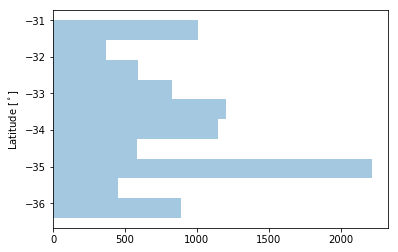

In [27]:
sns.distplot(onshore_timeseries,bins=10, vertical=True, kde=False);
plt.ylabel('Latitude [$^\circ$]')
plt.savefig('dipole_histogram_no_threshold_AVISO.png', dpi=300,bbox_inches='tight')

In [28]:
u_dipole = xr.concat(u_dipole,dim='time')
u_dipole

<xarray.DataArray (time: 9292)>
array([-0.29389 , -0.286743, -0.273854, ..., -0.512627, -0.51376 , -0.549734])
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-06-10
    latitude    (time) float32 -36.125 -36.125 -36.125 ... -33.375 -33.625
    longitude   (time) float32 150.625 150.625 150.625 ... 152.375 152.375
    concat_dim  (time) float64 -36.17 -36.17 -36.17 ... -33.48 -33.48 -33.7

## Impose threshold

In [29]:
# create a categorical  dataarray
dip_index = xr.full_like(u_dipole, 'none', dtype='U6')
dip_index[u_dipole >= -.25] = 'normal'
dip_index[u_dipole <= -.25] = 'dipole'
dip_index

<xarray.DataArray (time: 9292)>
array([u'dipole', u'dipole', u'dipole', ..., u'dipole', u'dipole', u'dipole'],
      dtype='<U6')
Coordinates:
  * time        (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-06-10
    latitude    (time) float32 -36.125 -36.125 -36.125 ... -33.375 -33.625
    longitude   (time) float32 150.625 150.625 150.625 ... 152.375 152.375
    concat_dim  (time) float64 -36.17 -36.17 -36.17 ... -33.48 -33.48 -33.7

## plot composites using threshold

/home/z3526974/anaconda2/lib/python2.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


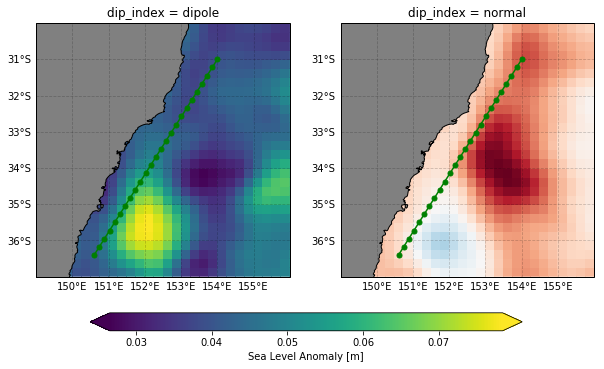

<Figure size 432x288 with 0 Axes>

In [32]:
sla_dipole_composite = ds.sla.groupby(dip_index.rename('dip_index')).mean(dim='time')

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
im = sla_dipole_composite.sel(dip_index='dipole').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
plt.plot(path_lons, path_lats, color='green', marker='o',markersize = 5)

ax1 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
feature = ax1.add_feature(coast, edgecolor='black',facecolor='gray')
sla_dipole_composite.sel(dip_index='normal').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax1.set_extent([149, 156, -37, -30])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
plt.plot(path_lons, path_lats, color='green', marker='o',markersize = 5)

cbar_ax = fig.add_axes([0.2, -0.0, .6, .05]) #left, bottom, width, height
fig.colorbar(im, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Sea Level Anomaly [m]')
plt.show()
plt.savefig('dipole_composite_025_AVISO.png', dpi=300,bbox_inches='tight')

In [33]:
sla_dipole_composite.sel(dip_index='dipole').count()

<xarray.DataArray 'sla' ()>
array(555)
Coordinates:
    dip_index  <U6 u'dipole'

## plot histogram of dipole composite, need to convert u_dipole to a dataframe to do this

In [34]:
df = u_dipole.to_dataframe(name = 'U');

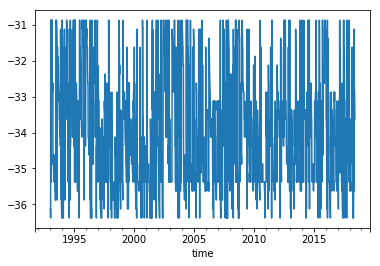

In [36]:
df.latitude.plot()

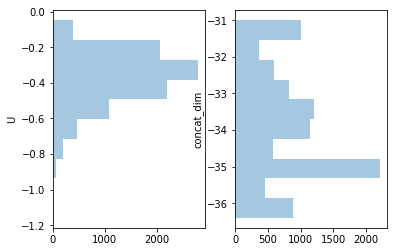

In [37]:
plt.subplot(1,2,1)
sns.distplot( df[ "U" ] ,bins=10, vertical = True, kde=False )
plt.subplot(1,2,2)
sns.distplot( df[ "concat_dim" ] ,bins=10, vertical = True, kde=False )

## Groupby threshold (in pandas this time)

In [38]:
dipole = df['U'] < -.25

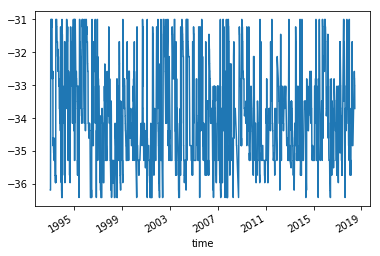

In [39]:
df[dipole].concat_dim.plot()

latitude      7350
longitude     7350
concat_dim    7350
U             7350
dtype: int64

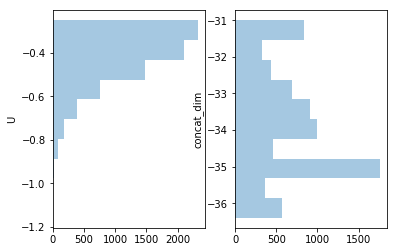

In [40]:
plt.subplot(1,2,1)
sns.distplot( df[dipole].U ,bins=10, vertical = True, kde=False )
plt.subplot(1,2,2)
sns.distplot( df[dipole].concat_dim ,bins=10, vertical = True, kde=False )
df[dipole].count()